In [5]:
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.configs import load_config_data
import os
os.environ["L5KIT_DATA_FOLDER"] = "/mnt/scratch/v_liuhaolan/l5kit_data"
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable
# get config
cfg = load_config_data("./visualization_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 10, 'future_num_frames': 30, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}}


In [10]:
from l5kit.data.map_api import MapAPI
from l5kit.rasterization.rasterizer_builder import load_metadata
import numpy as np

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = load_metadata(dm.require(cfg["raster_params"]["dataset_meta_key"]))
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)

map_api = MapAPI(semantic_map_filepath, world_to_ecef)

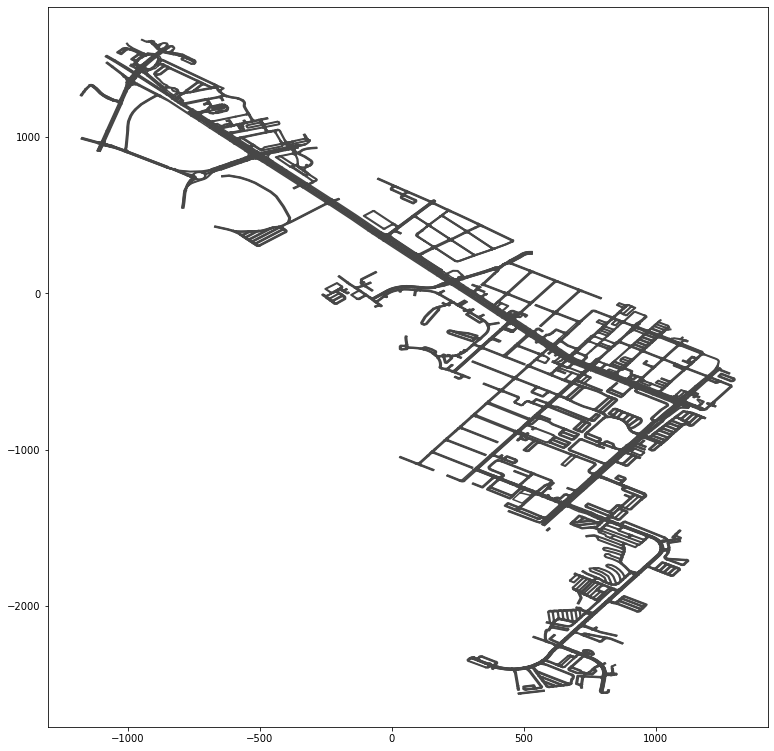

In [12]:
import matplotlib.pyplot as plt

MAP_LAYERS = ["junction", "node", "segment", "lane"]


def element_of_type(elem, layer_name):
    return elem.element.HasField(layer_name)


def get_elements_from_layer(map_api, layer_name):
    return [elem for elem in map_api.elements if element_of_type(elem, layer_name)]


class MapRenderer:
    
    def __init__(self, map_api):
        self._color_map = dict(drivable_area='#a6cee3',
                               road_segment='#1f78b4',
                               road_block='#b2df8a',
                               lane='#474747')
        self._map_api = map_api
    
    def render_layer(self, layer_name):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes([0, 0, 1, 1])
        
    def render_lanes(self):
        all_lanes = get_elements_from_layer(self._map_api, "lane")
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes([0, 0, 1, 1])
        for lane in all_lanes:
            self.render_lane(ax, lane)
        return fig, ax
        
    def render_lane(self, ax, lane):
        coords = self._map_api.get_lane_coords(MapAPI.id_as_str(lane.id))
        self.render_boundary(ax, coords["xyz_left"])
        self.render_boundary(ax, coords["xyz_right"])
        
    def render_boundary(self, ax, boundary):
        xs = boundary[:, 0]
        ys = boundary[:, 1] 
        ax.plot(xs, ys, color=self._color_map["lane"], label="lane")
        
renderer = MapRenderer(map_api)
fig, ax = renderer.render_lanes()